## K-Means Clustering with MNIST

This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.

In [1]:
%matplotlib inline

In [2]:
from sagemaker import get_execution_role
from sagemaker.session import Session

role = get_execution_role()
bucket = Session().default_bucket()

### Data ingestion

MNIST dataset [1] - 70K 28 x 28 pixel images of handwritten digits.  

In [3]:
import pickle, gzip, numpy, boto3, json

# Load the dataset
s3 = boto3.client("s3")
s3.download_file(f"sagemaker-sample-files", "datasets/image/MNIST/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

### Data inspection

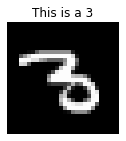

In [4]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2, 10)


def show_digit(img, caption="", subplot=None):
    if subplot is None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)


show_digit(train_set[0][30], f"This is a {train_set[1][30]}")

## Training the K-Means model

In [5]:
from sagemaker import KMeans

data_location = f"s3://{bucket}/kmeans_highlevel_example/data"
output_location = f"s3://{bucket}/kmeans_example/output"

print(f"training data will be uploaded to: {data_location}")
print(f"training artifacts will be uploaded to: {output_location}")

kmeans = KMeans(
    role=role,
    instance_count=2,
    instance_type="ml.c4.xlarge",
    output_path=output_location,
    k=10,
    data_location=data_location,
)

training data will be uploaded to: s3://sagemaker-us-east-1-623849366717/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-us-east-1-623849366717/kmeans_example/output


In [6]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-15 03:50:29 Starting - Starting the training job...
2022-03-15 03:50:57 Starting - Preparing the instances for trainingProfilerReport-1647316229: InProgress
.........
2022-03-15 03:52:22 Downloading - Downloading input data........Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/15/2022 03:53:38 INFO 140656735655744 integration.py:636] worker started
[03/15/2022 03:53:38 INFO 140656735655744] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_re

## Set up hosting for the model

Deploy the model we just trained behind a real-time hosted endpoint.

In [7]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


------!CPU times: user 130 ms, sys: 8.71 ms, total: 139 ms
Wall time: 3min 1s


## Validate the model for use
Finally, we'll validate the model for use. Let's generate a classification for a single observation from the trained model using the endpoint we just created.

In [8]:
result = kmeans_predictor.predict(train_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 3.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 7.570136070251465
    }
  }
}
]


In [9]:
%%time

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

CPU times: user 25.5 ms, sys: 0 ns, total: 25.5 ms
Wall time: 111 ms





Cluster 0:


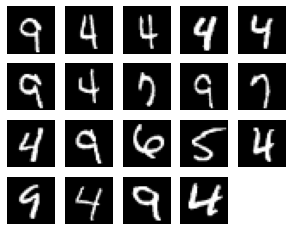




Cluster 1:


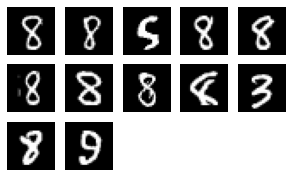




Cluster 2:


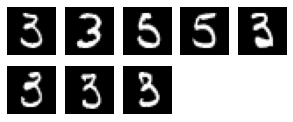




Cluster 3:


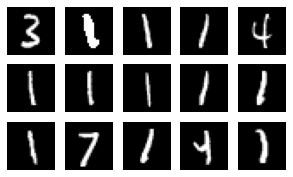




Cluster 4:


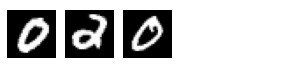




Cluster 5:


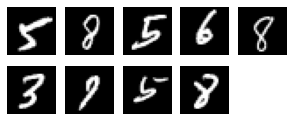




Cluster 6:


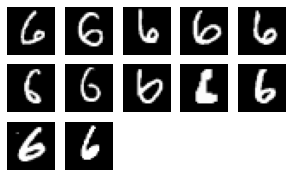




Cluster 7:


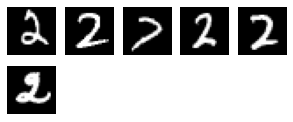




Cluster 8:


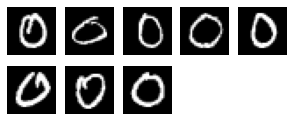




Cluster 9:


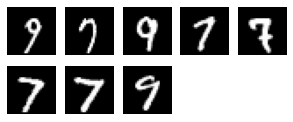

In [10]:
for cluster in range(10):
    print(f"\n\n\nCluster {int(cluster)}:")
    digits = [img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster]    
    '''
        The KMeans algorithm as an optimization problem is an NP Complete problem, and internal implementations
        can produce different results for each run, depending upon the locations of the initial cluster centroid.
        In some cases, there might be no data points in a cluster. We plot below the data points for clusters which
        have datapoints.
    '''
    if digits:        
        height = ((len(digits) - 1) // 5) + 1
        width = 5
        plt.rcParams["figure.figsize"] = (width, height)
        _, subplots = plt.subplots(height, width)
        subplots = numpy.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            show_digit(image, subplot=subplot)
        for subplot in subplots[len(digits) :]:
            subplot.axis("off")
        plt.show()

In [11]:
print(kmeans_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


kmeans-2022-03-15-03-54-14-907


In [12]:
#kmeans_predictor.delete_endpoint()